### This notebook lets me do analysis between a few models or a model across different temperatures and create a simple distance matrix

In [1]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from netrep.metrics import LinearMetric, GaussianStochasticMetric

np.random.seed(42)

# The parameters I ran the experiment with. 
PROMPTS = ["Once upon a time", "A long time ago"]

PROMPT = "Once upon a time"
PROMPT_LENGTH = 4
SEEDS = [100, 400, 900]
TEMPERATURES = [2, 5, 10]
NUM_EXPERIMENTS = 800
NUM_TOKENS = 20
HIDDEN_LAYER_SIZE = 64

# Let's me select the temperatures I want to measure. 
TEMP = []
TEMP = np.arange(len(TEMPERATURES))


### Load in the data 
prompt_a_data = None
prompt_b_data = None
per_trial_data = None

prompt_a_data = np.load('data/1M/2_1M_experiment800N_3_TEMPS_PROMPTA_per_trial_tensor.npy')
# prompt_b_data = np.load('data/3M/3M_experiment800N_9_TEMPS_PROMPTA_per_trial_tensor.npy')

if prompt_b_data is None:
    per_trial_data = prompt_a_data[TEMP]
    HIDDEN_LAYER_SIZE = per_trial_data.shape[-1]
elif prompt_a_data is None:
    per_trial_data = prompt_b_data[TEMP]
    HIDDEN_LAYER_SIZE = per_trial_data.shape[-1]

else:
    per_trial_data = np.empty((len(TEMPERATURES)*2, len(SEEDS), NUM_EXPERIMENTS,
                              PROMPT_LENGTH + NUM_TOKENS - 1, HIDDEN_LAYER_SIZE))
    per_trial_data[:3] = prompt_a_data
    per_trial_data[3:] = prompt_b_data[[0, 4, 6]]
    # TODO: Ask if I can zero pad the data. 

# Shape == (Temperature, Seed, Num_Experiments, Num_Classes, 64)

per_trial_data.shape

/opt/anaconda3/envs/lipshutz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(3, 3, 800, 23, 64)

## Apply PCA to reduce the number of neurons to the top 10 components

In [2]:
# Do PCA to reduce to 10 representative components. 
N_COMPONENTS = 10
pca = PCA(n_components=N_COMPONENTS)

per_trial_data_pca_shape = (len(TEMPERATURES), len(SEEDS), NUM_EXPERIMENTS,
                              PROMPT_LENGTH + NUM_TOKENS - 1, N_COMPONENTS)
per_trial_data_pca = np.empty(per_trial_data_pca_shape)
per_trial_data_pca.shape
for i in range(per_trial_data_pca.shape[0]):
    for j in range(per_trial_data_pca.shape[1]):
        for n in range(NUM_EXPERIMENTS):
            per_trial_data_pca[i, j, n, :, :] = pca.fit_transform(per_trial_data[i, j, n, :, :])
            # per_trial_data_pca[i, j, n, :, :] = per_trial_data[i, j, n, :, :10]

print(per_trial_data_pca.shape)

(3, 3, 800, 23, 10)


## Calculates the means of the trajectories

In [3]:
# Take the average over the number of experiments. 
mean_trajectories = np.mean(per_trial_data_pca, 2)
print(mean_trajectories.shape)

# Then reshape the trajectories into (Variables, Time points, Neurons)
mean_trajectories = mean_trajectories.reshape(len(TEMPERATURES) * len(SEEDS), PROMPT_LENGTH + NUM_TOKENS - 1, 10)
# reshaped = mean_trajectories.reshape(2 * len(SEEDS), PROMPT_LENGTH + NUM_TOKENS - 1, HIDDEN_LAYER_SIZE)

print(mean_trajectories.shape)

(3, 3, 23, 10)
(9, 23, 10)


## Caluclates the covariances for the trajectories

In [4]:
def cov3d(data):
    '''
    Calculates the covariance for a 3D array.
    Iterates over L (some number of parameters or samples) and calculates the covariance.
    '''
    if(len(data.shape) != 3):
        print("ERROR NOT 3D")
        return None

    L, N, M = data.shape
    covar_matrices = np.zeros((L, M, M))
    for i in range(L):
        covar_matrices[i] = np.cov(data[i, :, :], rowvar=False)
    
    return covar_matrices

reshaped_for_covar = per_trial_data_pca.reshape(len(TEMPERATURES) * len(SEEDS), PROMPT_LENGTH + NUM_TOKENS - 1, NUM_EXPERIMENTS,10)
# input to metric is (23, 10) and cov needs to be (23, 10, 10)
covars = []
for i in range(reshaped_for_covar.shape[0]):
    covar = cov3d(reshaped_for_covar[i])
    covars.append(covar)

print(covars[0].shape)

(23, 10, 10)


## Calculates the Linear (Procrustes) Distance Metric using the trajectory means

In [5]:
### LINEAR PROCRUSTES DISTANCE ###

linear_distances = [] # array of distances

# # Array of [ (Time points, Neurons), ... ]
Xs = []
for i in range(mean_trajectories.shape[0]):
    Xs.append(mean_trajectories[i])

print(Xs[0].shape)
alphas = [0, 0.5, 1] # alphas to use for linear metric

for alpha in alphas:
    metric = LinearMetric(alpha=alpha)
    test_dist, _ = metric.pairwise_distances(Xs)
    linear_distances.append(test_dist)

print(np.max(linear_distances))

(23, 10)
Parallelizing 36 distance calculations with 8 processes.


Computing distances: 100%|██████████| 36/36 [00:01<00:00, 18.13it/s]

Parallelizing 36 distance calculations with 8 processes.



Computing distances: 100%|██████████| 36/36 [00:01<00:00, 18.67it/s]

Parallelizing 36 distance calculations with 8 processes.



Computing distances: 100%|██████████| 36/36 [00:03<00:00, 10.78it/s]

0.9371852995725195


## Calculates the Gaussian (Stochastic) Distance Metric using means and covariances

In [6]:
### CALCULATES STOCHASTIC SHAPE DISTANCE ###
gaussian_distances = []

# Get covariance over N experiemnts and create input array
Xs = []

for i in range(mean_trajectories.shape[0]):
    Xs.append((mean_trajectories[i, :, :], covars[i]))


alphas = [0, 1, 2] # 0 only uses covar, 1 = 2-Wasserstein, 2 = only uses means
for alpha in alphas:
    metric = GaussianStochasticMetric(alpha=alpha, init='rand', n_restarts=50)
    test_dist, _ = metric.pairwise_distances(Xs)
    gaussian_distances.append(test_dist)


Parallelizing 36 distance calculations with 8 processes.


Computing distances: 100%|██████████| 36/36 [07:57<00:00, 13.27s/it]  

Parallelizing 36 distance calculations with 8 processes.



Computing distances: 100%|██████████| 36/36 [03:53<00:00,  6.49s/it]

Parallelizing 36 distance calculations with 8 processes.



Computing distances: 100%|██████████| 36/36 [00:03<00:00,  9.86it/s]


#### Compute graphs of the distance matrices and save them to disk

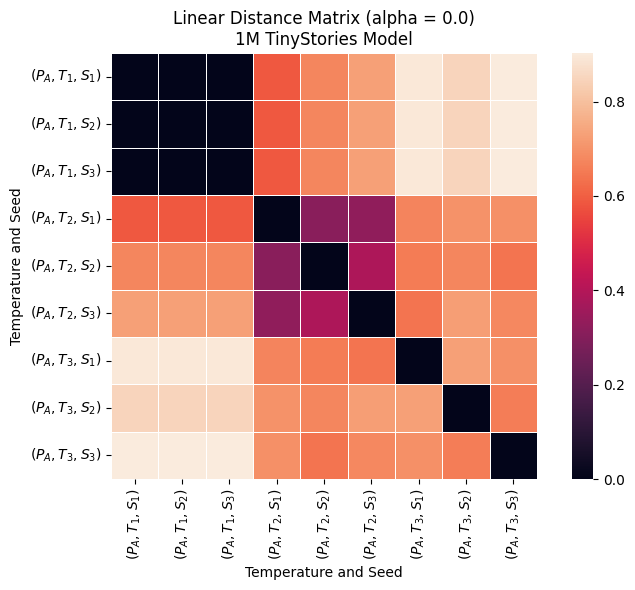

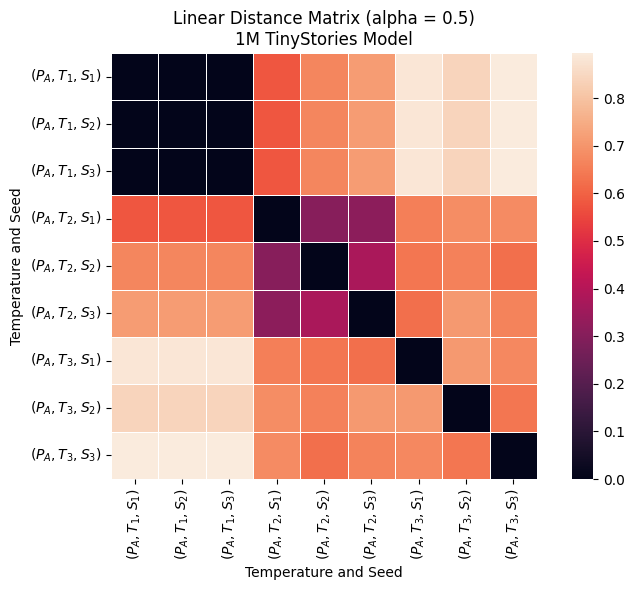

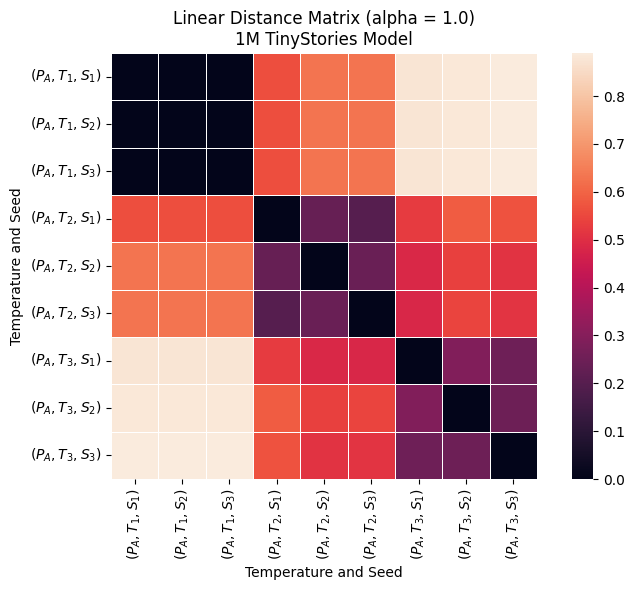

In [60]:


# For measuring 1 prompt
n_T, n_S = per_trial_data.shape[:2]
labels = [rf"$(P_A, T_{{{t+1}}}, S_{{{s+1}}})$" for t in range(n_T) for s in range(n_S)]

# For measuring 2 prompts at 1 temperature
# labels_a = [rf"$(P_A, T_x, S_{{{s+1}}})$" for s in range(n_S)]
# labels_b = [rf"$(P_B, T_x, S_{{{s+1}}})$" for s in range(n_S)]
# labels = labels_a+labels_b

label_title = "Temperature and Seed"
subtitle = "1M TinyStories Model"
# subtitle = f"\nT = {round(TEMPERATURES[TEMP], 1)}"

def save_graphs(distances, is_linear_distance=True):
    try:
        is_linear_distance = (distances == linear_distances)
    except:
        is_linear_distance = False
    
    for i in range(len(distances)):
        plt.figure(figsize=(8, 6)) # Adjust figure size as needed
        sns.heatmap(distances[i], 
                    xticklabels=labels,
                    yticklabels=labels,
                    square=True,
                    annot=False, 
                    fmt=".2f", 
                    linewidths=.5)
        
        title = f"{'Linear' if is_linear_distance else 'Gaussian'} Distance Matrix (alpha = { i/2.0 if is_linear_distance else i })"
        if(subtitle):
            title += "\n" + subtitle
        plt.title(title)
        plt.xlabel(label_title)
        plt.ylabel(label_title)


        plt.tight_layout()
        file_name = f"1M_{'linear' if is_linear_distance else 'gaussian'}_alpha_{i}.png"
        plt.savefig(f'results/{file_name}')

save_graphs(linear_distances)

/opt/anaconda3/envs/lipshutz/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


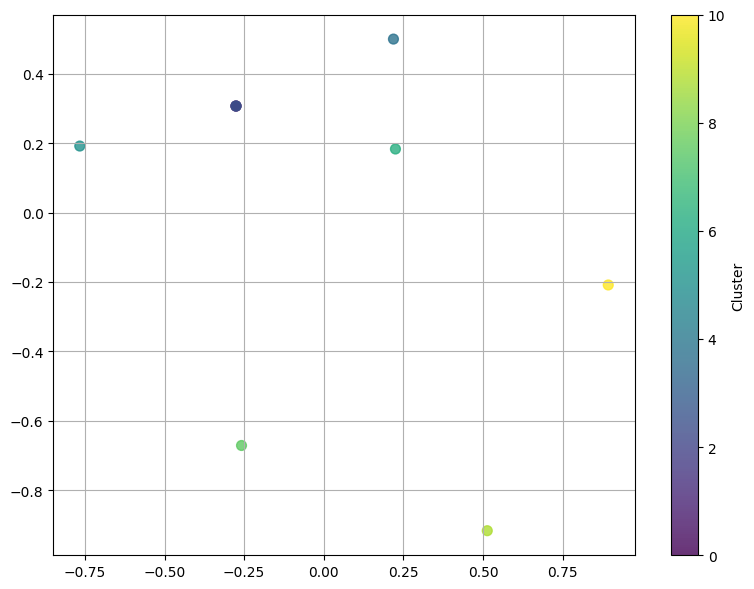

0.07139432829921227


In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, metric=False, dissimilarity='precomputed', normalized_stress=True)
clustered_data = mds.fit_transform(linear_distances[1])


degrees_freedom = np.linspace(0, len(clustered_data[:, 0])+1, len(clustered_data[:, 0]))
plt.figure(figsize=(8, 6)) # Adjust figure size as needed
scatter = plt.scatter(clustered_data[:, 0], clustered_data[:, 1], c=degrees_freedom, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

print(mds.stress_)